#### Data takem from: <br> 
https://www.kaggle.com/c/dogs-vs-cats

In [1]:
#loading libraries 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import random
import os

Using TensorFlow backend.


#### Data preprocessing:

In [2]:
# loadimg filenames and split them into categories
folder = 'C:/Users/andre/cats_dogs/train/train'
files = os.listdir(folder)
category = ['dog' if filename.split('.')[0] == 'dog' else 'cat' for filename in files]


In [3]:
#create  dataframe with filenames and corresponding categories:
data = pd.DataFrame({'filename': files, 'category': category})
data

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
...,...,...
24995,dog.9995.jpg,dog
24996,dog.9996.jpg,dog
24997,dog.9997.jpg,dog
24998,dog.9998.jpg,dog


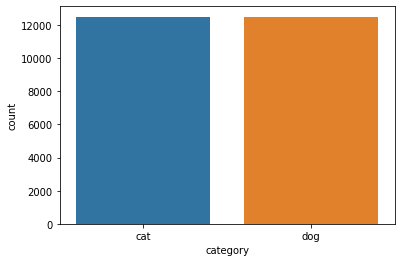

In [4]:
# let's see if categories are balanced
sns.countplot(x = data.category)
plt.show()


In [5]:
# split data into learning and validation parts:

learning = data.sample(frac=0.7,random_state=200)
validation = data.drop(learning.index)

# and split learning into train and test
train, test = train_test_split(learning, test_size=0.25, shuffle= True)

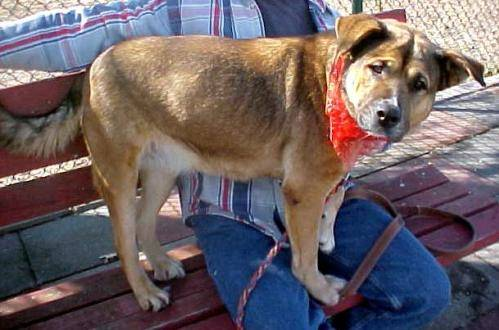

In [6]:
# Extract random image from dataset
sample = random.choice(files)
image = load_img(folder + '/' + sample)
image

In [7]:
# Generation of additional training data:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_dataframe(train, folder, x_col ='filename', y_col ='category', 
                                                    target_size =(128, 128),  class_mode='categorical')

Found 13125 validated image filenames belonging to 2 classes.


In [8]:
# and test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test, folder, x_col ='filename', y_col ='category', 
                                                    target_size =(128, 128),  class_mode='categorical')

Found 4375 validated image filenames belonging to 2 classes.


#### Model building:

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(filters= 32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
earlystop = EarlyStopping(patience=10)

callbacks = [earlystop, learning_rate_reduction]

In [11]:

batch_size = 15
history = model.fit_generator(
    train_generator, 
    epochs=50,
    validation_data=test_generator,
    validation_steps=test.shape[0]//batch_size,
    steps_per_epoch=train.shape[0]//batch_size,
    callbacks=callbacks
)

Epoch 1/50
875/875 [==============================] - 1491s 2s/step - loss: 0.6605 - accuracy: 0.6938 - val_loss: 0.5978 - val_accuracy: 0.7189
Epoch 2/50
875/875 [==============================] - 1478s 2s/step - loss: 0.4347 - accuracy: 0.8002 - val_loss: 0.8921 - val_accuracy: 0.7202
Epoch 3/50
875/875 [==============================] - 1479s 2s/step - loss: 0.3829 - accuracy: 0.8333 - val_loss: 0.9112 - val_accuracy: 0.6932
Epoch 4/50
875/875 [==============================] - 1476s 2s/step - loss: 0.3393 - accuracy: 0.8546 - val_loss: 0.3327 - val_accuracy: 0.8507
Epoch 5/50
875/875 [==============================] - 1476s 2s/step - loss: 0.3259 - accuracy: 0.8589 - val_loss: 0.4901 - val_accuracy: 0.8363
Epoch 6/50
875/875 [==============================] - 1478s 2s/step - loss: 0.2960 - accuracy: 0.8772 - val_loss: 4.0901 - val_accuracy: 0.5817

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
875/875 [==============================] - 1

#### Check quality of the model:

In [12]:
X_validation = validation.drop('category', axis=1)
y_validation = validation.drop('filename', axis=1)
val_gen = ImageDataGenerator(rescale=1./255) 
validation_generator = val_gen.flow_from_dataframe(
    X_validation, 
    folder, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=batch_size,
    shuffle=False
)

Found 7500 validated image filenames.


In [13]:
predict = model.predict_generator(validation_generator, steps = X_validation.shape[0] /batch_size)

In [14]:
#To evaluate accuracy, replace cat and dog with 0 and 1 in category column

y_validation['predicted'] = predict.argmax(axis=1)
y_validation['cat_proba'] = predict[:,0]
y_validation['dog_proba'] = predict[:,1]

y_validation.category = y_validation.category.apply(lambda x: 1 if x == 'dog' else 0)

y_validation

,category,predicted,cat_proba,dog_proba
3,0,0,0.981137,0.018863
4,0,0,0.999899,0.000101
5,0,0,0.999607,0.000393
15,0,0,0.986305,0.013695
17,0,1,0.233018,0.766982
...,...,...,...,...
24981,1,1,0.004211,0.995789
24984,1,1,0.487228,0.512772
24988,1,1,0.000381,0.999619
24990,1,1,0.002109,0.997891


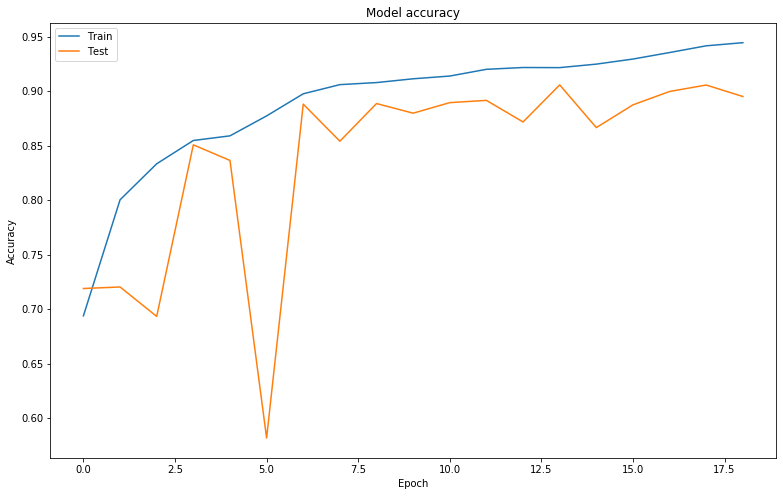

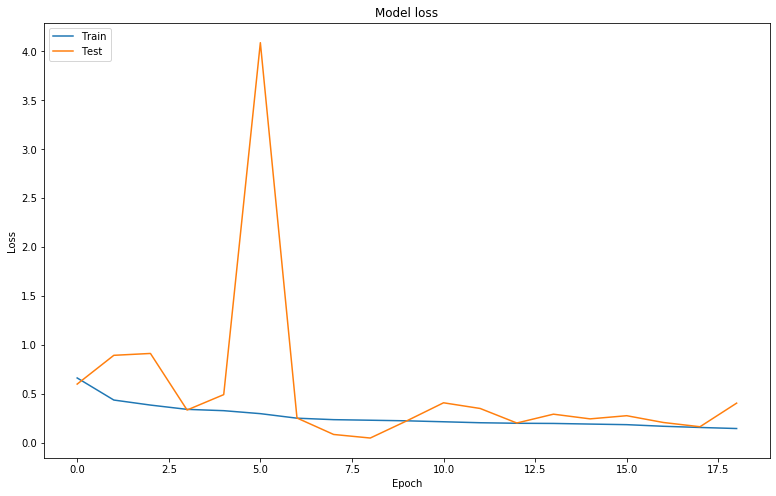

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
from sklearn.metrics import accuracy_score
print('Achieved accuracy score is {}'.format(accuracy_score(y_validation.category, y_validation.predicted)))

Achieved accuracy score is 0.9053333333333333


In [17]:
# let's see some images and corresponding probabilities where model made the biggest mistakes 

X_validation = X_validation.merge(y_validation, left_index=True, right_index=True)
mistakes = X_validation[(X_validation.category != X_validation.predicted)]

In [18]:
mistakes

,filename,category,predicted,cat_proba,dog_proba
17,cat.10011.jpg,0,1,0.233018,0.766982
118,cat.10102.jpg,0,1,0.356349,0.643651
139,cat.10121.jpg,0,1,0.060265,0.939735
162,cat.10142.jpg,0,1,0.348708,0.651292
225,cat.102.jpg,0,1,0.422010,0.577990
...,...,...,...,...,...
24649,dog.9683.jpg,1,0,0.959526,0.040474
24663,dog.9696.jpg,1,0,0.555377,0.444623
24755,dog.9779.jpg,1,0,0.567044,0.432956
24778,dog.98.jpg,1,0,0.991682,0.008318


Mistakenly identified cats:


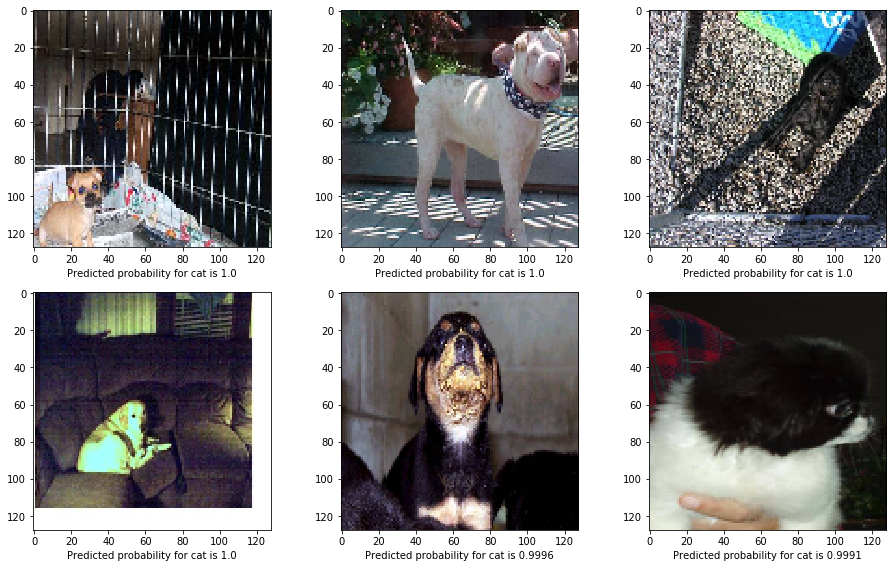

In [19]:
print('Mistakenly identified cats:')
plt.figure(figsize=(13,8))
for index, row in mistakes.sort_values(['category', 'cat_proba'], ascending=False).head(6).reset_index().iterrows():
    filename = row['filename']
    category = round(row['cat_proba'],4)
    plt.subplot(2, 3, index+1)
    plt.imshow(load_img(folder + '/' +filename, target_size=(128,128)))
    plt.xlabel('Predicted probability for cat is {}'.format(category))
plt.tight_layout()
plt.show()

Mistakenly identified dogs:


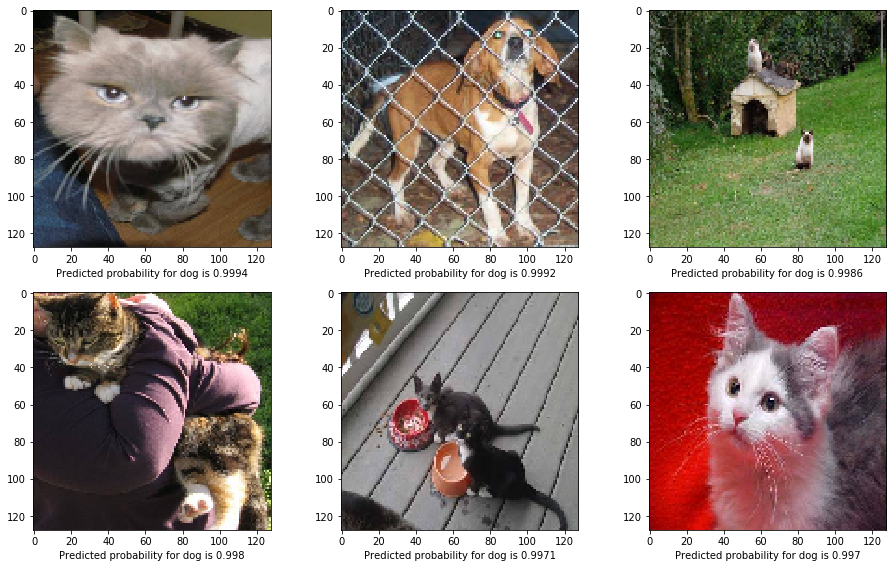

In [20]:
print('Mistakenly identified dogs:')
plt.figure(figsize=(13,8))
for index, row in mistakes.sort_values(['category', 'cat_proba']).head(6).reset_index().iterrows():
    filename = row['filename']
    category = round(row['dog_proba'],4)
    plt.subplot(2, 3, index+1)
    plt.imshow(load_img(folder + '/' +filename, target_size=(128,128)))
    plt.xlabel('Predicted probability for dog is {}'.format(category))
plt.tight_layout()
plt.show()

As we see, some of mistakes is made due to faults in markup <br>
#### Let's see how the model identifies my own pets:

In [21]:
path = 'C:/Users/andre/cats_dogs/check'
folder1 = os.listdir(path)
validate = pd.DataFrame({'filename': folder1})

In [22]:
validation_generator1 = val_gen.flow_from_dataframe(
    validate,
    'C:/Users/andre/cats_dogs/check',
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=batch_size,
    shuffle=False
)


Found 6 validated image filenames.


In [23]:
predict = model.predict_generator(validation_generator1)

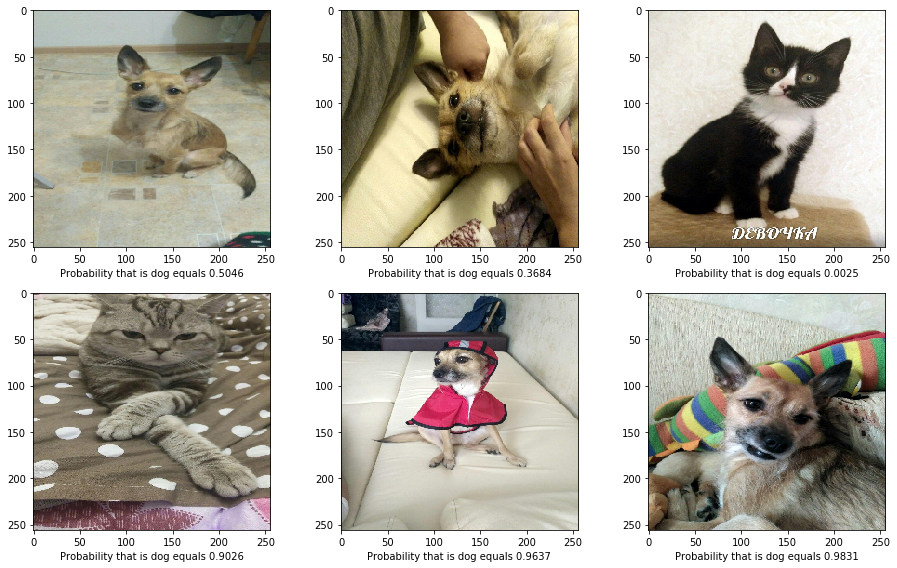

In [24]:
validate['cat_proba'] = predict[:, 0]
validate['dog_proba'] = predict[:, 1]
plt.figure(figsize=(13,8))
for index, row in validate.iterrows():
    filename = row['filename']
    category = round(row['dog_proba'],4)
    plt.subplot(2, 3, index+1)
    plt.imshow(load_img(path + '/' +filename, target_size=(256,256)))
    plt.xlabel('Probability that is dog equals {}'.format(category))
plt.tight_layout()
plt.show()

Definetely, model needs improvements:)